In [1]:
import numpy as np
import importlib, os, datetime, pickle
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML, Image
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from quick_sim import setup_sim


# import edward_tools.fq_runner as fq_runner
from edward_tools.coupled_fq_potential import coupled_flux_qubit_non_linear_approx_pot, coupled_flux_qubit_non_linear_approx_force, \
coupled_flux_qubit_non_linear_approx_pot_special, coupled_flux_qubit_non_linear_approx_force_special, coupled_flux_qubit_non_linear_approx_pot_break_down
from edward_tools.visualization import animate_sim_flux_qubit, plotFidelityBarChart, separate_by_state_2
from edward_tools.initial_state_sampling import extra_constraint_00_and_11_only
from NAND_PARAMETERS import *
import importlib

import kyle_tools as kt
import matplotlib.pyplot as plt


from edward_tools import coupled_fq_protocol_library, cfq_runner
from edward_tools import coupled_fq_protocol_library

import edward_tools.cfq_batch_sweep as cfq_batch_sweep
import edward_tools.Analysis_tool.general_analysis_tools as general_analysis_tool
# from edward_tools.Analysis_tool.general_analysis_tools import show_phi_dc_with_time
import edward_tools.Analysis_tool.minimum_value_of_potential as minimum_value_of_potential
from edward_tools.couple_flux_qubit_metrics import fidelityEvaluation
from edward_tools import visualization

coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_along_a_1D_cutline = coupled_fq_protocol_library.get_potential_along_a_1D_cutline
plotCutlines = coupled_fq_protocol_library.plotCutlines

# parameters

### circuit parameters

In [2]:
circuit_params_from_Chris = {
    "L": 5e-12 * 1, "T":4.2, "L_factor": 1, 
    "beta": 2.3, "d_beta": 0,
    "phi_1x": 0.61,   "phi_2x": 0.10, "phi_1xdc": 0, "phi_2xdc": 1.79, "M_12": 0.06
}

experiment_circuit_params = {
    "L": 5e-12, "T": 4.2, "L_factor": 1,
    "beta": 2.3, "d_beta": 0,
    "phi_1x": 0.58,   "phi_2x": 0.095, "phi_1xdc": 0, "phi_2xdc": 1.96,
    "M_12": 0.055
}


circuit_params_best_work_done = {
    "L": 5e-12 * 1, "T":4.2, "L_factor": 1, 
    "beta": 2.3, "d_beta": 0,
    "phi_1x": 0.59,   "phi_2x": 0.09, "phi_1xdc": 0, "phi_2xdc": 1.90, "M_12": 0.052
}



phi_1x_value = 0.4
phi_2x_value = 0.4
phi_1xdc_value = 0.1
phi_2xdc_value = 1.7
m_12_value = 0.1

circuit_params_crazy = {
    "L": 5e-12 * 1, "T":4.2, "L_factor": 1, 
    "beta": 2.3, "d_beta": 0,
    "phi_1x": phi_1x_value,   "phi_2x": phi_2x_value, "phi_1xdc": phi_1xdc_value, "phi_2xdc": phi_2xdc_value, 
    "M_12": m_12_value
}

    
# phi_1x_value = 0.5
#         phi_2x_value = 0.5
#         phi_1xdc_value = 0.1
#         phi_2xdc_value = 1.9
#         m_12_value = 0.6


circuit_params_chosen = circuit_params_best_work_done
circuit_params_chosen = circuit_params_crazy
experiment_comment = "Experiment 3 (2024-10-22): Failed KE extraction protocol simulation for Kyle's animation"

phi_1_x_on_12, phi_2_x_on_12, phi_1_dcx_on_12, phi_2_dcx_on_12, phi_1_x_on_21, phi_2_x_on_21, phi_1_dcx_on_21, phi_2_dcx_on_21, M_12_on, four_well, CE_1, CE_8, lower_H_wells, flip_H, lower_V_wells, flip_V, KE_extraction_protocol_for_CE_1, KE_extraction_protocol_for_CE_8 = generate_protocols_from_circuit_params(circuit_params_chosen)

T = 4.2, L = 5e-12
phi_1_x_on_12 = 0.4, phi_2_x_on_12 = 0.4, phi_1_dcx_on_12 = 0.1, phi_2_dcx_on_12 = 1.7, M_12_on = 0.1


In [3]:
has_velocity = True

PHI_0 = 2.067833848 * 1e-15
k_B = 1.38e-23
T = circuit_params_chosen["T"]
# T = 0.1
# T = 7
k_BT = k_B * T

C_factor = 1
L_factor = circuit_params_chosen['L_factor']
R_factor = 500
# I_m_factor = 50
# I_m_factor = 15
I_m_factor = 0
time_scale = 1.0



I_p_1, I_p_2 = 5e-6 , 5e-6  # Amp
I_m_1, I_m_2 = 7e-9 * I_m_factor, 7e-9 * I_m_factor                           # Amp
R_1, R_2 = 1 * R_factor, 1 * R_factor                                         # ohm
C_1, C_2 = 500e-15 * C_factor, 500e-15 * C_factor                             # F

L_1, L_2 = 140e-12 * L_factor, 140e-12 * L_factor                             # H 
L_1, L_2 = 5e-12 * L_factor, 5e-12 * L_factor                             # H 
freq = 1/np.sqrt(C_1 * L_1)
characteristic_time = np.sqrt(C_1 * C_factor * L_1 * L_factor)



In [4]:

m_c = C_1
m_1 = C_1
m_2 = C_2
x_c = PHI_0 / (2 * np.pi)
time_scale_factor = 1
t_c = np.sqrt(L_1 * C_1)
v_c = x_c / t_c


U0_1 = m_c * x_c**2 / t_c**2 / k_BT
U0_2 = m_2 * x_c**2 / t_c**2 / k_BT
kappa_1, kappa_2, kappa_3, kappa_4 = 1/U0_1, 1/U0_1, 1/U0_1, 1/U0_1

lambda_1 = 2 * np.sqrt(L_1 * C_1) / (C_1 * R_1)
theta_1  = 1
eta_1    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(2 * kappa_1 / 1**2)

lambda_2 = 2 * np.sqrt(L_1 * C_1) / (C_2 * R_2)
theta_2  = 1 / (C_2/C_1)
eta_2    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(2 * kappa_2 * (R_1 * C_1**2) / (R_2 * C_2**2))

lambda_3 = 2 * np.sqrt(L_1 * C_1) / (C_1 * R_1)
theta_3  = 4
eta_3    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(8 * kappa_3)

lambda_4 = 2 * np.sqrt(L_1 * C_1) / (C_2 * R_2)
theta_4  = 4 / (C_2/C_1)
eta_4    = np.sqrt(np.sqrt(L_1 * C_1)/ (R_1 * C_1)) * np.sqrt(8 * kappa_4 * (R_1 * C_1**2) / (R_2 * C_2**2))

gamma = 10


beta_1 = 2 * np.pi * L_1 * I_p_1 / PHI_0; 
beta_2 = 2 * np.pi * L_2 * I_p_2 / PHI_0;

beta_1 = 2.3
beta_2 = 2.3

# beta_1 = 2
# beta_2 = 2



d_beta_1 = 2 * np.pi * L_1 * I_m_1 / PHI_0; 
d_beta_2 = 2 * np.pi * L_2 * I_m_2 / PHI_0;


_damping_factor = 1
_lambda = np.array([lambda_1, lambda_2, lambda_3, lambda_4])
_theta  = np.array([theta_1, theta_2, theta_3, theta_4])
_eta  =   np.array([eta_1, eta_2, eta_3, eta_4])

v_1 = np.random.normal(0, np.sqrt(k_BT/m_1)) / v_c
v_2 = np.random.normal(0, np.sqrt(k_BT/m_2)) / v_c
v_3 = np.random.normal(0, np.sqrt(k_BT/(m_1/4))) / v_c
v_4 = np.random.normal(0, np.sqrt(k_BT/(m_2/4))) / v_c

In [5]:
print(f"L_1 = {L_1 * 1e12:.3g}pH, T = {T}K")
print(f"freq = {freq / 1e9:.3g}GHz")
print(characteristic_time)
print(1/U0_1*50)

L_1 = 5pH, T = 4.2K
freq = 632GHz
1.5811388300841897e-12
0.13378174065129397


In [6]:
U0_1

373.7430815041229

In [7]:
k_BT / (x_c**2/L_1) * 50

0.13378174065129395

### parameter setting

In [8]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params = {}
params['N'] = 1000
params['dt'] = 1/100
params['lambda'] = 1
params['beta'] = 1
params['sim_params'] = [_lambda, _theta, _eta]
params['target_work'] = None
params['applyOffset'] = False
params['measureWorkWithOffset'] = True
params['monitor_work_dist_in_whole_process'] = True # To monitor the work process
params['comment'] = experiment_comment
params['capacitance'] = np.array([C_1, C_2, C_1/4, C_2/4])
params['mass'] = np.array([1, 1, 1/4, 1/4])
params['v_c'] = x_c/t_c
params['k_BT'] = k_BT
params['U0'] = U0_1
params['as_step'] = np.s_[::10] # the time step to skep for the all_state
params['percentage'] = 1 # For what percentage of the total sample do you want to keep in the output all_state


In [9]:
"""
# step 2: Define initial condition and protocol
"""
manual_domain=[np.array([-10, -10]), np.array([10, 10])]



# µ = 0.06, φ2xdc = 1.79, φ1x = 0.59, and φ2x = 0.10.
    
initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": gamma,  "gamma_2": gamma,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": phi_1_x_off,  "phi_2_x": phi_2_x_off,  "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_1_dcx_off,
        "M_12": M_12_off, 'x_c': x_c
}


In [10]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor
contour_range = [300, 2000]
    
coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

# coupled_fq_pot = Potential(coupled_flux_qubit_pot_with_offset_at_00_xy, coupled_flux_qubit_force, 14, 4,\
#                            default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

coupled_fq_pot = Potential(coupled_flux_qubit_non_linear_approx_pot, coupled_flux_qubit_non_linear_approx_force, 14, 4,\
                           default_params = initial_parameter_dict,  relevant_domain = coupled_fq_domain)

# coupled_fq_pot = Potential(coupled_flux_qubit_non_linear_approx_pot_special, coupled_flux_qubit_non_linear_approx_force_special, 14, 4,\
                           # default_params = initial_parameter_dict,  relevant_domain = coupled_fq_domain)

### protocol setting

In [11]:
zeroDissipation = False
# zeroDissipation = True

saveAllStates = True

params['sim_params'] = [_lambda, _theta, _eta]

if zeroDissipation:
    params['sim_params'] = [_lambda * 0, _theta, _eta * 0]

params['circuit_parameters'] = {
    "C_factor":C_factor, "L_factor": L_factor, "R_factor": R_factor, "I_m_factor": I_m_factor, "T": T, 
    "I_p_1": I_p_1, "I_p_2": I_p_2, "I_m_1": I_m_1, "I_m_2": I_m_2,
    "R_1": R_1, "R_2": R_2, "C_1": C_1, "C_2": C_2, "L_1": L_1, "L_2": L_2, 
    "characteristic_time": np.sqrt(C_1 * C_factor * L_1 * L_factor),
    "phi_1_x_on": phi_1_x_on_12, "phi_2_x_on": phi_2_x_on_12,
    "phi_1_dcx_on": phi_1_dcx_on_12, "phi_2_dcx_on": phi_2_dcx_on_12, "M_12_on": M_12_on,
    "gamma": gamma
}


initial_state_used_choice = ["four_well", "after_CE_8_completed"]



# bookmark
initial_parameter_dict["phi_1_dcx"] = circuit_params_chosen["phi_1xdc"]
initial_parameter_dict["phi_2_dcx"] = circuit_params_chosen["phi_2xdc"]
initial_parameter_dict["phi_1_x"]   = circuit_params_chosen["phi_1x"]
initial_parameter_dict["phi_2_x"]   = circuit_params_chosen["phi_2x"]
initial_parameter_dict["M_12"]      = circuit_params_chosen["M_12"]

initial_parameter_dict["phi_1_dcx"] = 0
initial_parameter_dict["phi_2_dcx"] = 0
initial_parameter_dict["phi_1_x"]   = 0
initial_parameter_dict["phi_2_x"]   = 0
initial_parameter_dict["M_12"]      = 0

In [12]:
initial_parameter_dict

{'U0_1': 373.7430815041229,
 'U0_2': 373.7430815041229,
 'gamma_1': 10,
 'gamma_2': 10,
 'beta_1': 2.3,
 'beta_2': 2.3,
 'd_beta_1': 0.0,
 'd_beta_2': 0.0,
 'phi_1_x': 0,
 'phi_2_x': 0,
 'phi_1_dcx': 0,
 'phi_2_dcx': 0,
 'M_12': 0,
 'x_c': 3.291059784019349e-16}

### modify the protocol

In [16]:
CE_1 = {
        "phi_1_x": phi_1_x_on_12, "phi_2_x": phi_2_x_on_12, "M_12": M_12_on, \
        "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on_12, "name":"CE_1"
}

KE_extraction_protocol_for_CE_1 = {
        "phi_1_x": phi_1_x_on_12, "phi_2_x": 0.00, "M_12": 0.00, \
        "phi_1_dcx": phi_1_dcx_on_12, "phi_2_dcx": phi_2_dcx_on_12,\
        "name":"KE_extraction_protocol"
}

crazy_protocol = {
        "phi_1_x": 0, "phi_2_x": 0, "M_12": 0.4, \
        "phi_1_dcx": np.pi, "phi_2_dcx": 2, "name":"crazy_CE_1"
}

In [17]:
CE_1

{'phi_1_x': 0.4,
 'phi_2_x': 0.4,
 'M_12': 0.1,
 'phi_1_dcx': 0,
 'phi_2_dcx': 1.7,
 'name': 'CE_1'}

In [18]:
protocol_type = "CE"

if protocol_type == "CE":
    mapping_dict = mapping_state_1_to_state_2_dict_CE
if protocol_type == "NAND":
    mapping_dict = mapping_state_1_to_state_2_dict_NAND



protocol_list_variable_duration_with_KE_extraction_sudden = [
    # forward
    
    create_CE_Protocol(50, CE_1),
    # create_CE_Protocol(, CE_1),
    create_CE_Protocol(100, KE_extraction_protocol_for_CE_1),
    create_CE_Protocol(100, KE_extraction_protocol_for_CE_1),
    create_CE_Protocol(50, four_well)

]


sudden_jump_on_the_other_side_old = {
    'phi_1_x': 0.61,
     'phi_2_x': 0.1,
     'M_12': 0.100,
     'phi_1_dcx': 0,
     'phi_2_dcx': 1.6,
     'name': 'sudden_jump'
}

sudden_jump_on_the_other_side = {
    'phi_1_x': 0.7,
     'phi_2_x': 0.1,
     'M_12': 0.08,
     'phi_1_dcx': 0,
     'phi_2_dcx': 1.7,
     'name': 'sudden_jump'
}

time_factor = 0.1
protocol_list_variable_duration_with_KE_extraction_slow = [
    # forward
    
    create_CE_Protocol(100, CE_1),
    create_CE_Protocol(120 * time_factor, KE_extraction_protocol_for_CE_1),
    create_CE_Protocol(80 * time_factor, KE_extraction_protocol_for_CE_1),
    create_CE_Protocol(100, four_well)

]


protocol_list_variable_duration_with_KE_extraction_sudden = [
    # forward
    
    create_CE_Protocol(100, CE_1),
    create_CE_Protocol(7, CE_1),
    
    create_CE_Protocol(0.1, sudden_jump_on_the_other_side),
    create_CE_Protocol(100, sudden_jump_on_the_other_side),
    # create_CE_Protocol(180, sudden_jump_on_the_other_side),
    # create_CE_Protocol(0.5, KE_extraction_protocol_for_CE_1),
    # create_CE_Protocol(80, KE_extraction_protocol_for_CE_1),
    # create_CE_Protocol(120, KE_extraction_protocol_for_CE_1),
    create_CE_Protocol(100, four_well)

]


# protocol_list_variable_duration_without_KE_extraction = [
#     # forward
    
#     create_CE_Protocol(100, CE_1),
#     create_CE_Protocol(100, CE_1),
#     create_CE_Protocol(100, four_well)

# ]
t_factor_CE_protocol = 0.5
CE_t_1, CE_t_2, CE_t_3 = 30, 10, 100
protocol_list_variable_duration_without_KE_extraction = [
    # forward
    
    create_CE_Protocol(CE_t_1 * t_factor_CE_protocol, CE_8),
    create_CE_Protocol(CE_t_2 * t_factor_CE_protocol, CE_8),
    create_CE_Protocol(CE_t_3 * t_factor_CE_protocol, four_well)

]


protocol_list_variable_duration_without_KE_extraction = [
    # forward
    
    create_CE_Protocol(50, crazy_protocol),
    create_CE_Protocol(50, four_well)

]




fixed_time = 1000

protocol_list_NAND_protocol = [
    # forward
    create_CE_Protocol(100, CE_8),
    create_CE_Protocol(50, CE_8),
    create_CE_Protocol(100, four_well),

    create_CE_Protocol(500, lower_V_wells),
    create_CE_Protocol(250, flip_V),

    create_CE_Protocol(500, lower_H_wells),
    create_CE_Protocol(250, flip_H),
    create_CE_Protocol(500, four_well),
]

KE_extraction = True
KE_extraction = False

sudden_protocol = True
sudden_protocol = False




if KE_extraction:
    if sudden_protocol:
        protocol_list = protocol_list_variable_duration_with_KE_extraction_sudden
    else:
        protocol_list = protocol_list_variable_duration_with_KE_extraction_slow
else:
    protocol_list = protocol_list_variable_duration_without_KE_extraction
# params['as_step'] = np.s_[::] # the time step to skep for the all_state

# protocol_list = protocol_list_NAND_protocol

def tellMeImportantFactors(protocol):
    print(f"N = {params['N']}, dt = {1/params['dt']}")
    print(f"T = {T} K, L = {L_1} H, beta = {beta_1}")
    print(f"R = {R_1} Ω, C = {C_1} F")
    print(f"phi_1x = {phi_1_x_on_12}, phi_2x = {phi_2_x_on_12}, phi_1xdc = {phi_1_dcx_on_12}, phi_2xdc = {phi_2_dcx_on_12}, M_12 = {M_12_on}")
    for x in protocol:
        print(x)

In [19]:
tellMeImportantFactors(protocol_list)

N = 1000, dt = 100.0
T = 4.2 K, L = 5e-12 H, beta = 2.3
R = 500 Ω, C = 5e-13 F
phi_1x = 0.4, phi_2x = 0.4, phi_1xdc = 0.1, phi_2xdc = 1.7, M_12 = 0.1
{'duration': 50, 'phi_1_x': 0, 'phi_2_x': 0, 'M_12': 0.4, 'phi_1_dcx': 3.141592653589793, 'phi_2_dcx': 2, 'name': 'crazy_CE_1'}
{'duration': 50, 'phi_1_x': 0, 'phi_2_x': 0, 'M_12': 0, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'name': 'four well'}


# setting protocol (click here!)

In [20]:
# protocol_list = [
#     create_CE_Protocol(50, {
#         "phi_1_x": 0, "phi_2_x": 0, "M_12": 0,  
#         "phi_1_dcx": 0, "phi_2_dcx": 1.8, "name":"lower barrier"
#     }),
#     # create_CE_Protocol(100, {
#     #     "phi_1_x": 0, "phi_2_x": 0, "M_12": 0,  
#     #     "phi_1_dcx": 0, "phi_2_dcx": 2.5, "name":"lower barrier"
#     # }),
#     # create_CE_Protocol(100, {
#     #     "phi_1_x": 0, "phi_2_x": 0, "M_12": 0,  
#     #     "phi_1_dcx": 0, "phi_2_dcx": np.pi, "name":"lower barrier"
#     # }),
#     # create_CE_Protocol(fixed_time, flip_V),
#     create_CE_Protocol(50, four_well)

# ]

# first initialization

### create initial state 

In [21]:
%%capture
initial_state_array = ["saved_init_state/four_well_default_init_state_N_1000.npy", "saved_init_state/after_CE_8_completed_N_1000z.npy", "saved_init_state/just_before_KEP_N_1000.npy"]
initial_state_chosen = initial_state_array[0]


regenerate_init_state = False
# regenerate_init_state = True
if regenerate_init_state:
    initial_potential_protocol_list = [create_CE_Protocol(200*100*params['dt'], four_well)]
    init_params = params.copy()
    # friction_factor = 1
    # init_params['sim_params'] = [init_params['sim_params'][0] * friction_factor, init_params['sim_params'][1], init_params['sim_params'][2] * friction_factor]
    init_params['dt'] = 1/500
    init_state_saved = cfq_batch_sweep.create_initial_state(initial_parameter_dict, initial_potential_protocol_list, coupled_fq_pot, init_params)
else:
    init_state_saved = np.load(initial_state_chosen)

init_state_used = init_state_saved

# np.save("four_well_default_init_state_N_1000.npy", init_state_saved)

# particle_index = visualization.separate_by_state_2(init_state_saved[:, (0, 1), :])
# init_state_used = init_state_saved[particle_index["00"]]
# [1.3, 0.3, 0.3, 0.3, 1]

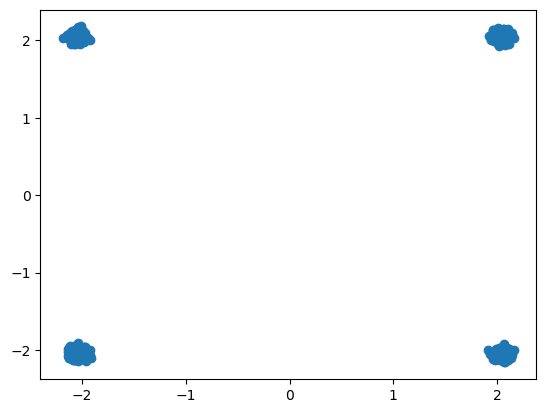

In [22]:
plt.scatter(init_state_saved[..., 0, 0], init_state_saved[..., 1, 0])

### create cfqr object

In [23]:
"""
# step 3: create the relevant storage protocol and computation protocol
"""
def modifiedFunction(t, result):
    return result


computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict, modifiedFunction = None)

cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol, \
                                         protocol_list = protocol_list, \
                                        has_velocity=has_velocity)

protocol_time_array, protocol_time_index_array, protocol_all_time_array, protocol_time_all_index_array = cfqr.createProtocolTimeArray(protocol_list, params)
cfqr.initialize_sim()
# cfqr.set_sim_attributes(init_state=init_state_saved)
cfqr.set_sim_attributes(init_state=init_state_used)
print(f"mean KE = {np.mean(cfqr.system.get_kinetic_energy(init_state_used))}")

[None, None]
use old initial_state
as step value: slice(None, None, 10), sampleSize: 1000
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py, sim_params:  [array([0.01264911, 0.01264911, 0.01264911, 0.01264911]), array([1., 1., 4., 4.]), array([0.00581759, 0.00581759, 0.01163519, 0.01163519])]
from quick_sim.py
gamma: [0.01264911 0.01264911 0.01264911 0.01264911], theta: [1. 1. 4. 4.] and eta: [0.00581759 0.00581759 0.01163519 0.01163519]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 100.0
from simulation.py: number of steps: 10000, dt: 0.01
mean KE = 2.0513626443356423


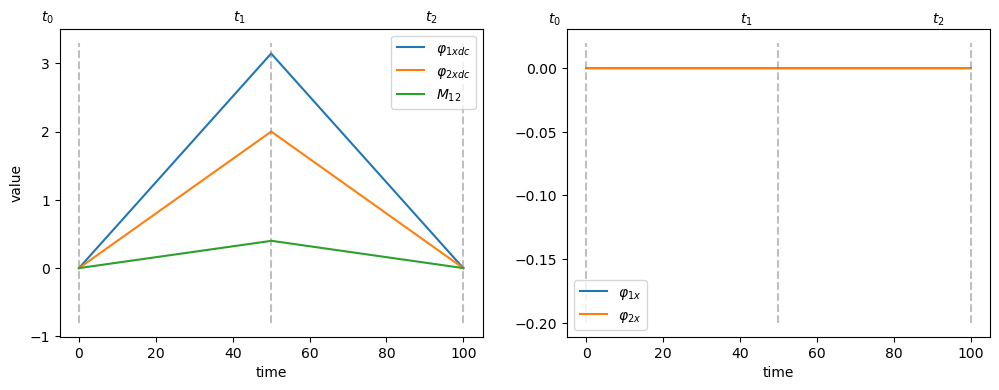

In [24]:
cfqr.showPamameterTimeGraph(protocol_time_array, protocol_all_time_array)

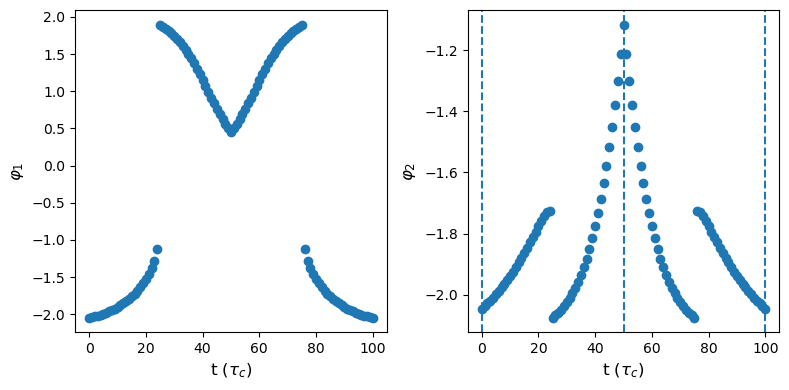

In [25]:
_stepped_time = protocol_all_time_array[::100]
minimum_points_of_00 = [cfqr.get_minimum_at_t_for_a_set_of_parameter(_t, initial_parameter_dict, guess = [(-2, -2)])[0] for _t in _stepped_time]
fig, ax = plt.subplots(1, 2, figsize = [8, 4])

ax[0].scatter(_stepped_time, np.array(minimum_points_of_00)[:, 0])
ax[0].set_xlabel(r't $(\tau_c)$', fontsize = 12)
ax[0].set_ylabel(r'$\varphi_1$', fontsize = 12)

ax[1].scatter(_stepped_time, np.array(minimum_points_of_00)[:, 1])
ax[1].set_xlabel(r't $(\tau_c)$', fontsize = 12)
ax[1].set_ylabel(r'$\varphi_2$', fontsize = 12)

y_min, y_max = ax[1].set_ylim()
for _t in protocol_time_array:
    ax[1].vlines(x = _t, ymin = y_min, ymax = y_max, linestyle = "--")



fig.tight_layout()



# actual simulations

In [26]:
## importlib.reload(cfq_batch_sweep)

# 0.5 * (x - 0.59)^2 + 0.5 * (y - 0.1)^2 + 2.3 * cos(x) + 2.3 * cos(y)
# step 5: perform simulations


manual_domain=[np.array([-5, -5]), np.array([5, 5])]

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                        potential = coupled_fq_pot, potential_default_param = coupled_fq_default_param, mapping_state_1_to_state_2_dict = mapping_dict,         
                        initial_state = init_state_used, manual_domain = manual_domain, \
                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, measure_all_states=saveAllStates, \
                        has_velocity = has_velocity)
print(f"characteristic_time = {characteristic_time * 10e9:.3g}ns")

started at  2025-02-13 16:05:28.737099
None
[None, None]

 initializing...
use old initial_state
as step value: slice(None, None, 10), sampleSize: 1000
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py, sim_params:  [array([0.01264911, 0.01264911, 0.01264911, 0.01264911]), array([1., 1., 4., 4.]), array([0.00581759, 0.00581759, 0.01163519, 0.01163519])]
from quick_sim.py
gamma: [0.01264911 0.01264911 0.01264911 0.01264911], theta: [1. 1. 4. 4.] and eta: [0.00581759 0.00581759 0.01163519 0.01163519]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 100.0
from simulation.py: number of steps: 10000, dt: 0.01

 running sim...
slice(None, None, 10) slice(None, None, 1000)
work_done_offset9999
final_state
all_state

 analyzing output...
finished at  2025-02-13 16:06:08.303463
time_duration: 39.56636309623718, sim_id: 4b3223e311dd879896bcf616c6f65b4116a610838131d4b935c55294f0eaade5
characteristic_time = 0.0158ns


In [27]:
print(f"characteristic_time = {characteristic_time * 10e9:.3g}ns, freq = {1/characteristic_time * 10e-9:.3g} GHz")

characteristic_time = 0.0158ns, freq = 6.32e+03 GHz


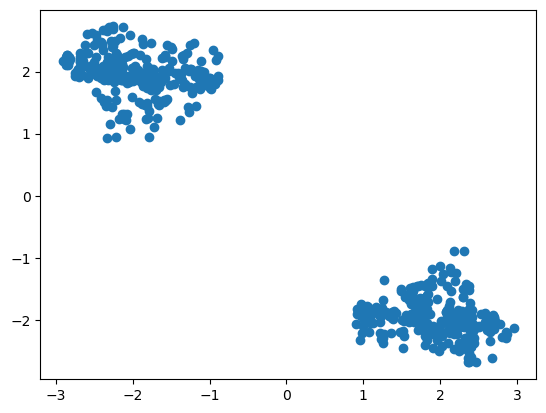

In [28]:
final_state = simResult['cfqr'].get_all_state()[:,-1,...]
plt.scatter(final_state[:,0,0], final_state[:,1,0])

# sim Results

### fidelity

sim_id =  {'simulation_time': 39.56636309623718, 'simulation_date': '2025-02-13 16:06:08.303463', 'simulation_id': '4b3223e311dd879896bcf616c6f65b4116a610838131d4b935c55294f0eaade5', 'pickle_save_path': None}
N = 1000, dt = 0.01, T = 4.2K, N_00 = 1000
lambda = [0.01264911 0.01264911 0.01264911 0.01264911]
theta = [1. 1. 4. 4.]
eta = [0.00581759 0.00581759 0.01163519 0.01163519]
L_factor = 1, C_factor = 1, I_m_factor = 0, gamma = 10
[50, 50]
jarzyn = 2.39e-12, mean work = 305 ± 23.6
total_error_rate: 74.9%, N = 1000
barrier_height = 471
average KE = 78.13803603486748
None


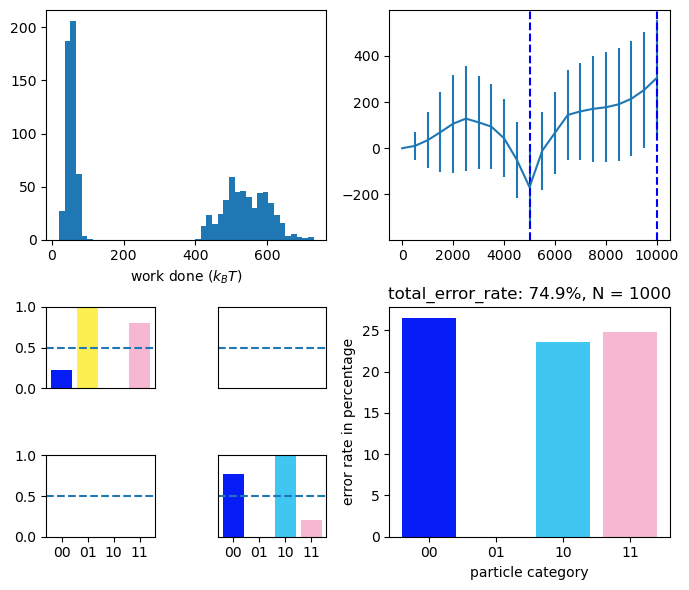

In [29]:
import sys, importlib
# importlib.reload(sys.modules['edward_tools.jupyter_helper_function'])
from edward_tools.jupyter_helper_function import work_analysis, KE_analysis, single_particle_analysis, fidelity_analysis, work_done_of_each_type
fidelity_analysis(simResult, params, initial_parameter_dict, protocol_list)
print(simResult['simulation_data']['pickle_save_path'])

# work done of each type

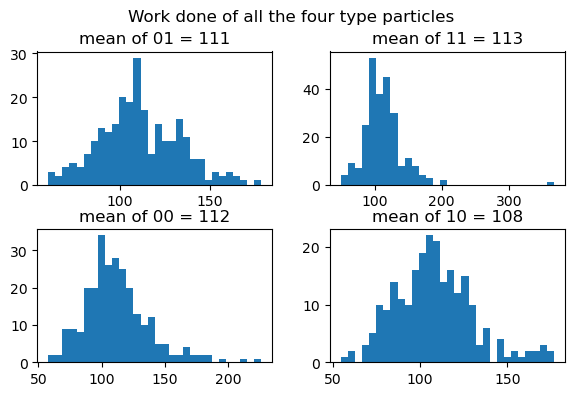

In [68]:
work_done_of_each_type(simResult)

In [177]:
tellMeImportantFactors(protocol_list)

N = 1000, dt = 100.0
T = 4.2 K, L = 5e-12 H, beta = 2.3
R = 5 Ω, C = 5e-13 F
phi_1x = 0.4, phi_2x = 0.4, phi_1xdc = 0.1, phi_2xdc = 1.7, M_12 = 0.1
{'duration': 50, 'phi_1_x': 0, 'phi_2_x': 0, 'M_12': 0.6, 'phi_1_dcx': 1.32, 'phi_2_dcx': 1.32, 'name': 'crazy_CE_1'}
{'duration': 50, 'phi_1_x': 0, 'phi_2_x': 0, 'M_12': 0.6, 'phi_1_dcx': 1.32, 'phi_2_dcx': 1.32, 'name': 'crazy_CE_1'}


###  single particle analysis

max KE: 583, max PE: 1.99e+03


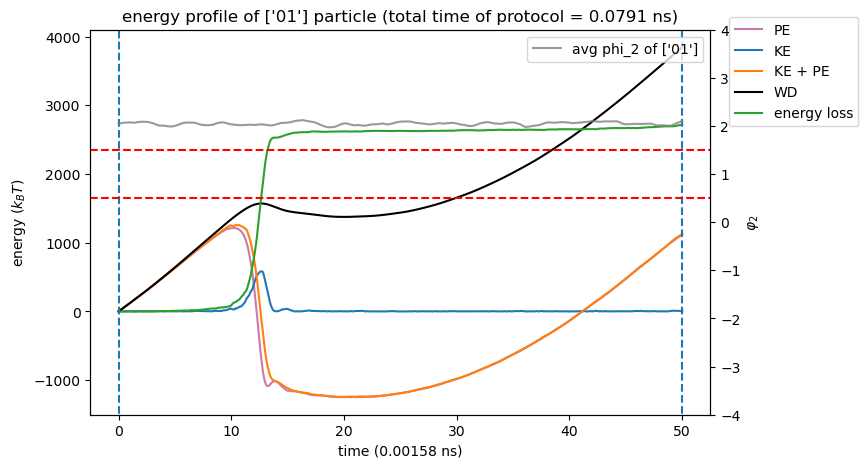

In [29]:
import sys, importlib
importlib.reload(sys.modules['edward_tools.jupyter_helper_function'])
from edward_tools.jupyter_helper_function import work_analysis, KE_analysis, single_particle_analysis, fidelity_analysis, work_done_of_each_type
all_states = simResult['cfqr'].get_all_state()

particle_category = ["01"]
particle_index = 6

for _c in particle_category:
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    index_choice = simResult['cfqr'].getIndexOfParticles()[_c]
    reduced_data = single_particle_analysis(simResult, params, protocol_list, plot_ax = ax1, 
                             particle_index=particle_index, particle_category= _c, 
                             time_range=None)
    reduced_protocal_time_array = reduced_data["reduced_protocal_time_array"]
    index_slice = reduced_data["index_slice"]

    # print(simResult['cfqr'].protocol_time_array)
    y_min, y_max = ax1.set_ylim()
    x_min, x_max = ax1.set_xlim()
    for _t in simResult['cfqr'].protocol_time_array:
        plt.vlines(x=_t, ymin = y_min, ymax = y_max, linestyles="--")


    all_states_00_i1 = all_states[index_choice][particle_index, ...]
    mean_phi_2 = all_states_00_i1[:, 1, 0]
    # mean_phi_1 = np.mean(all_states[index_choice][:, :, 0, 0], axis = 0)


    ax2.plot(reduced_protocal_time_array, mean_phi_2, alpha =0.8, color = "grey", label = f"avg phi_2 of {particle_category}")
    ax2.set_ylim(-4, 4)
    ax2.set_ylabel(r"$\varphi_{2}$")

    ax2.hlines(1.5, x_min, x_max, color = "red", linestyle = "--")
    ax2.hlines(0.5, x_min, x_max, color = "red", linestyle = "--")
    ax1.set_title(f"energy profile of {particle_category} particle (total time of protocol = {protocol_time_array[-1] * characteristic_time * 1e9:.3g} ns)")
    ax2.legend()
    plt.show()

In [30]:
particle_category

['01']

max KE: 583, max PE: 1.99e+03


IndexError: index 501 is out of bounds for axis 0 with size 501

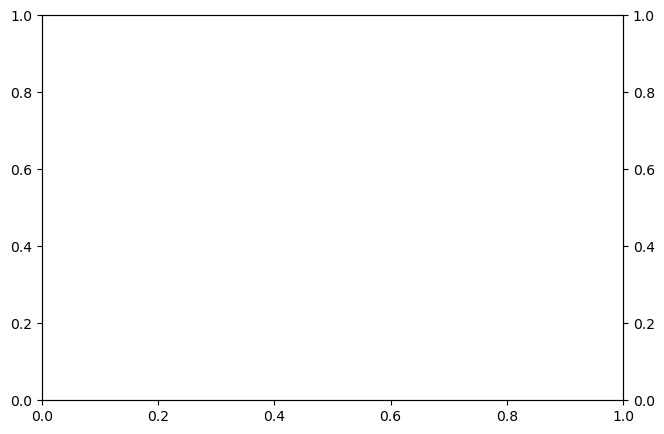

In [31]:
fig, ax1 = plt.subplots(figsize=(7.5, 5))
ax2 = ax1.twinx()

reduced_data = single_particle_analysis(simResult, params, protocol_list, plot_ax = ax1, particle_index = particle_index, particle_category= particle_category[0], time_range=[100, 123])

reduced_protocal_time_array = reduced_data["reduced_protocal_time_array"]
index_slice = reduced_data["index_slice"]

ax2.plot(reduced_protocal_time_array[index_slice], mean_phi_2[index_slice], alpha =0.8, color = "grey", label = f"avg phi_2 of {particle_category}")
ax2.set_ylim(-4, 4)
ax2.set_ylabel(r"$\varphi_{2}$")
y_min, y_max = ax1.set_ylim()
x_min, x_max = ax1.set_xlim()

ax1.set_title(f"energy profile of {particle_category} particle (total time of protocol = {protocol_time_array[-1] * characteristic_time * 1e9:.3g} ns)")

ax2.hlines(1.5, x_min, x_max, color = "red", linestyle = "--")
ax2.hlines(0.5, x_min, x_max, color = "red", linestyle = "--")



# show state at time t

In [33]:
def search_protocol_time_array_index(array, start):
    x = np.sort(np.append(array, start))
    
    start_index = np.where(x == start)[0][0]
    if start != round(array[start_index]):
        start_index += 1
    return start_index

In [34]:
import imageio

In [35]:
all_states_of_00 = all_states[simResult['cfqr'].getIndexOfParticles()["00"]]
all_states_of_01 = all_states[simResult['cfqr'].getIndexOfParticles()["01"]]
all_states_of_10 = all_states[simResult['cfqr'].getIndexOfParticles()["10"]]
all_states_of_11 = all_states[simResult['cfqr'].getIndexOfParticles()["11"]]
np.save("state_for_no_KE_extraction/all_states_of_00.npy", all_states_of_00)
np.save("state_for_no_KE_extraction/all_states_of_01.npy", all_states_of_01)
np.save("state_for_no_KE_extraction/all_states_of_10.npy", all_states_of_10)
np.save("state_for_no_KE_extraction/all_states_of_11.npy", all_states_of_11)
np.save("state_for_no_KE_extraction/reduced_protocol_time_array.npy", reduced_protocal_time_array)


chosen_state = "01"
prefix = "KEP (no)"
if chosen_state == "00":
    plot_states = all_states_of_00
if chosen_state == "01":
    plot_states = all_states_of_01
if chosen_state == "10":
    plot_states = all_states_of_10
if chosen_state == "11":
    plot_states = all_states_of_11
target_index_array = []
animation_picture = []
for t in np.linspace(100, 123, 50):
    target_index = search_protocol_time_array_index(reduced_protocal_time_array, t)
    
    
    if target_index in target_index_array:
        continue
    else:
        target_index_array.append(t)
    
    target_state = plot_states[:, target_index, ...]
    mean_position = np.mean(target_state[:, 0, 0]), np.mean(target_state[:, 1, 0])
    mean_speed = np.mean(target_state[:, 0, 1]), np.mean(target_state[:, 1, 1])
    
    
    fig, ax = plt.subplots(1,1, figsize = [5, 5])
    ax.set_aspect(1)
    ax.scatter(target_state[:, 0, 0], target_state[:, 1, 0])
    ax.scatter(mean_position[0], mean_position[1], color = "red")
    ax.arrow(mean_position[0], mean_position[1], dx = mean_speed[0], dy = mean_speed[1], color = "yellow", width = 0.05)
    ax.set_title(f"particle: {chosen_state}, time = {t:.4g}")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    
    pic_name = "cfq_data/sudden_jump_KEP/" + f"{prefix}_{chosen_state}_{len(target_index_array)}.png"
    plt.savefig(pic_name)
    plt.close(fig)

    animation_picture.append(imageio.imread(pic_name))

imageio.mimsave(f"cfq_data/sudden_jump_KEP/{prefix}_{chosen_state}_particle.gif", animation_picture, loop = 0, duration=0.1)


IndexError: index 401 is out of bounds for axis 0 with size 401

In [36]:
# np.save("saved_init_state/after_CE_completed_N_1000.npy", target_state)

In [37]:
np.mean(cfqr.system.get_kinetic_energy(target_state))

NameError: name 'target_state' is not defined

In [38]:
reduced_protocal_time_array

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

# mean position of the particle

In [39]:
all_states_of_00 = all_states[simResult['cfqr'].getIndexOfParticles()["00"]]

Text(0.5, 0.01, 'time')

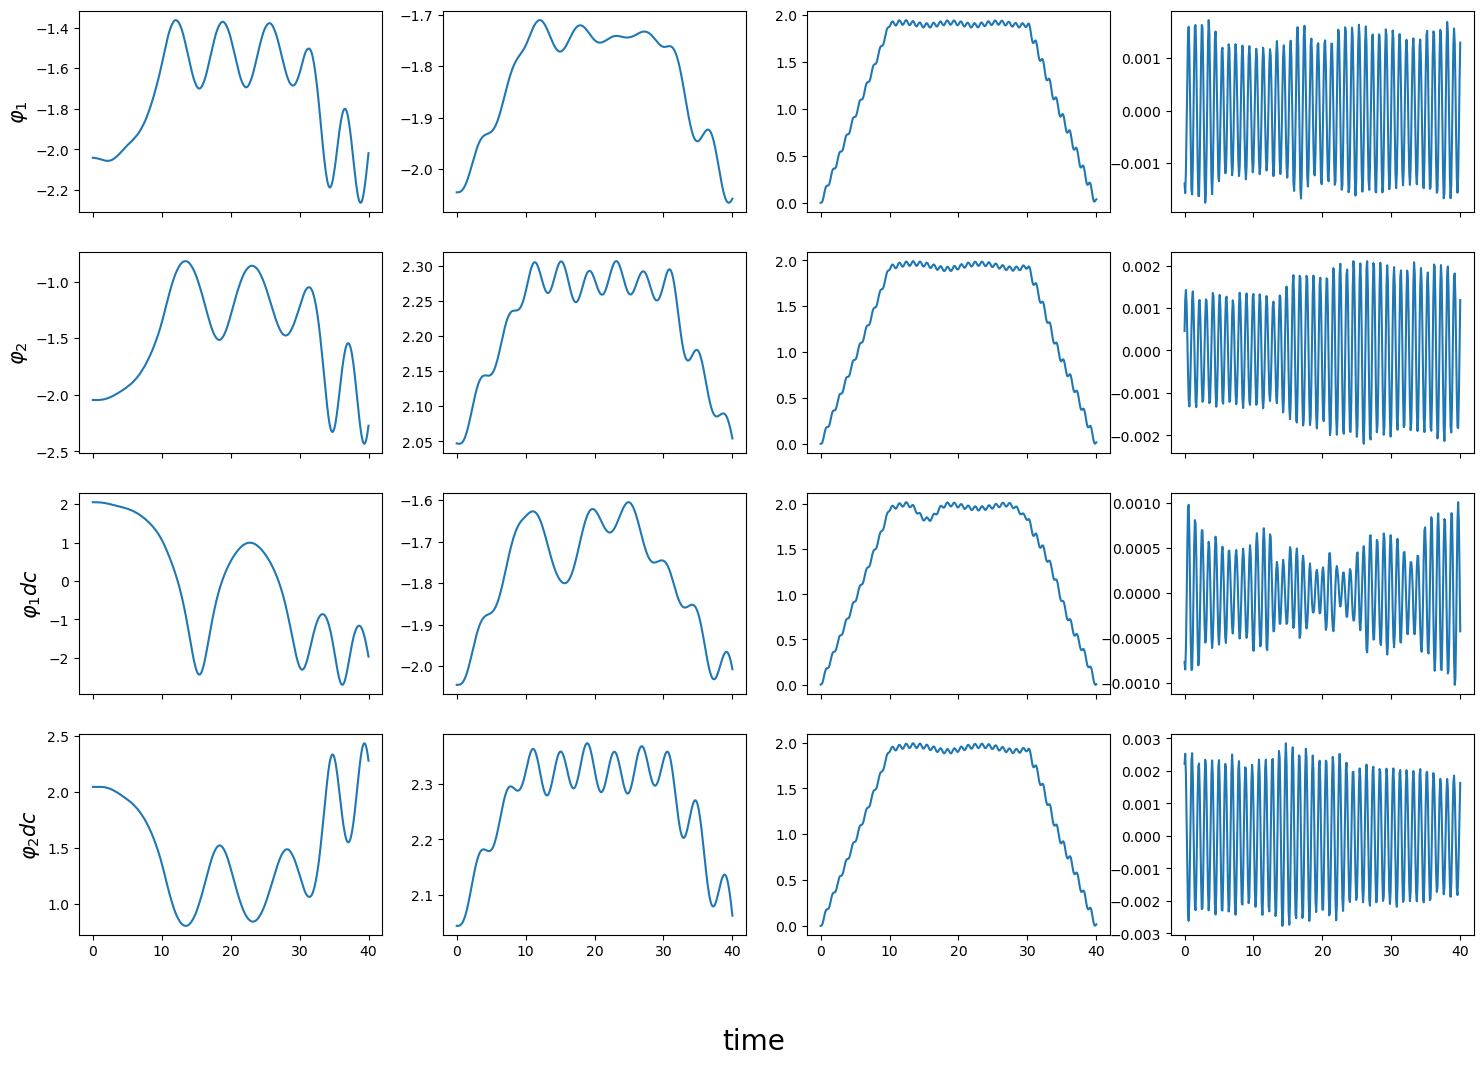

In [40]:

all_state = simResult['cfqr'].sim.output.all_state['states']
reduced_time_array = simResult['cfqr'].getReducedTimeArray()
index_of_00 = simResult['cfqr'].getIndexOfParticles()["00"]
index_of_01 = simResult['cfqr'].getIndexOfParticles()["01"]
index_of_10 = simResult['cfqr'].getIndexOfParticles()["10"]
index_of_11 = simResult['cfqr'].getIndexOfParticles()["11"]
index_of_not_00 = ~simResult['cfqr'].getIndexOfParticles()["00"]

fig, ax = plt.subplots(4, 4, figsize = [18, 12], sharex=True)

for i, index_of_particle in enumerate([index_of_00, index_of_01, index_of_10, index_of_11]):
    v_1 = np.mean(all_state[index_of_particle, :, 0, 0], axis = 0)
    v_2 = np.mean(all_state[index_of_particle, :, 1, 0], axis = 0)
    v_1dc = np.mean(all_state[index_of_particle, :, 2, 0], axis = 0)
    v_2dc = np.mean(all_state[index_of_particle, :, 3, 0], axis = 0)
    ax[i][0].plot(reduced_time_array, v_1)
    ax[i][1].plot(reduced_time_array, v_2)
    ax[i][2].plot(reduced_time_array, v_1dc)
    ax[i][3].plot(reduced_time_array, v_2dc)
ax[0][0].set_ylabel(r"$\varphi_1$", size = 15)
ax[1][0].set_ylabel(r"$\varphi_2$", size = 15)
ax[2][0].set_ylabel(r"$\varphi_1dc$", size = 15)
ax[3][0].set_ylabel(r"$\varphi_2dc$", size = 15)
fig.supxlabel('time', size = 20)



# KE Analysis

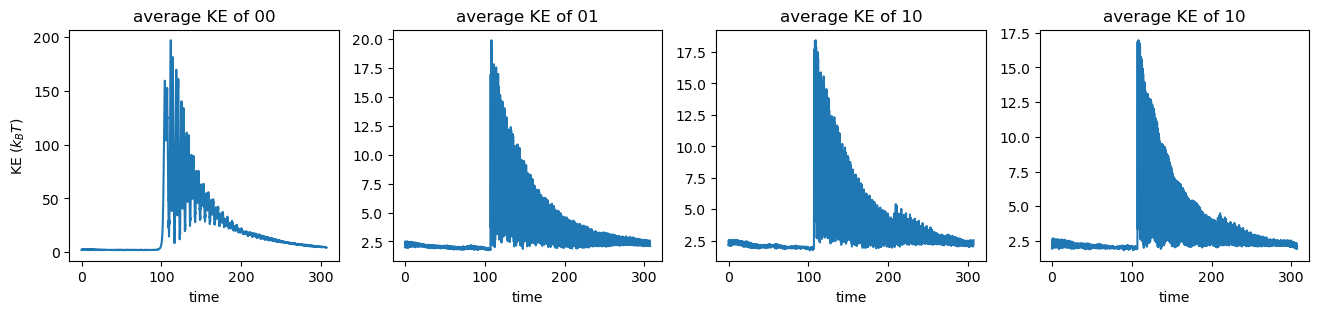

In [510]:
KE_analysis(simResult)

# v analysis

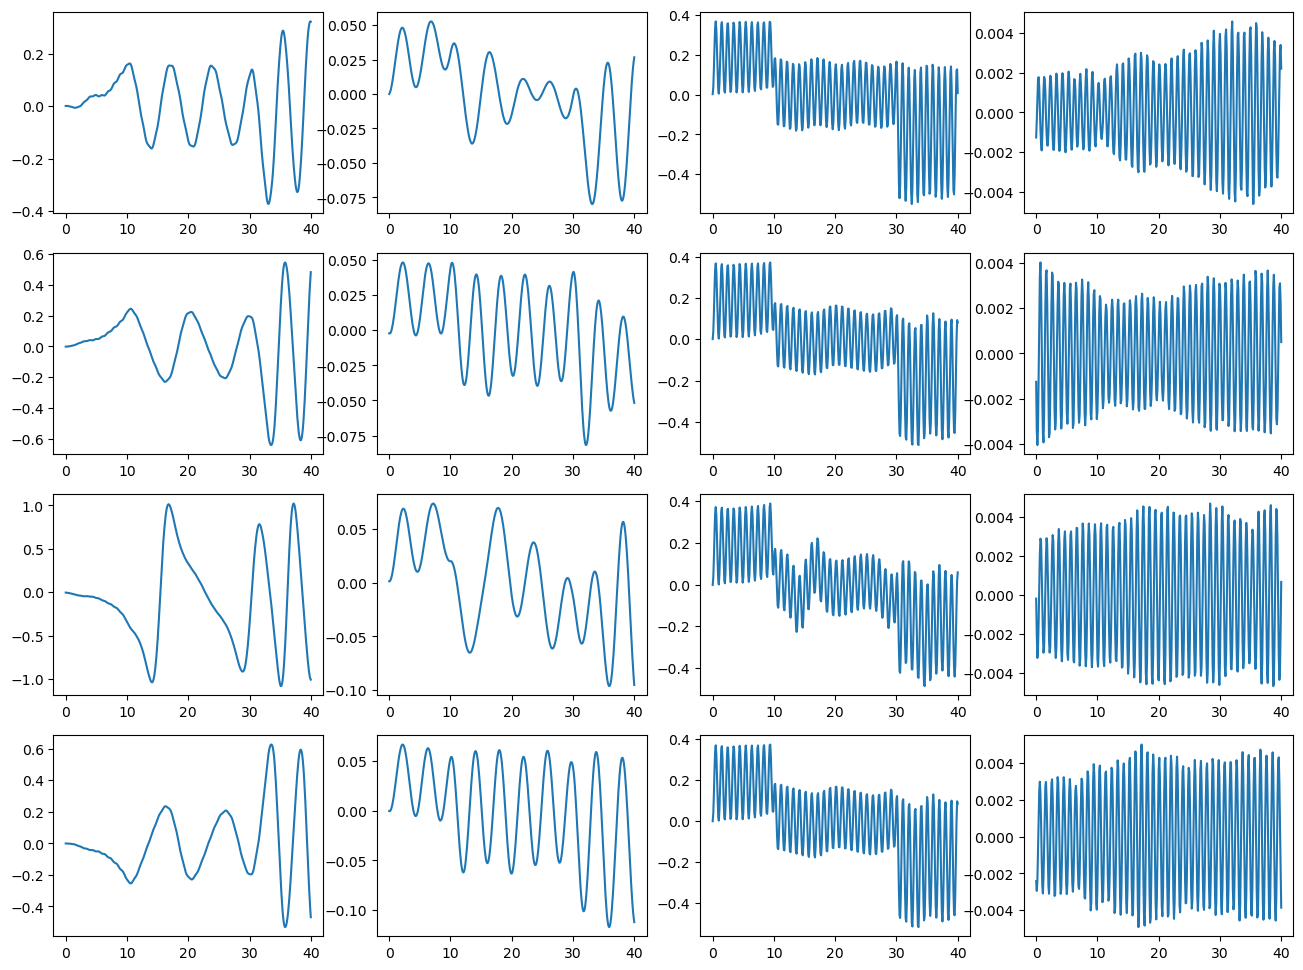

In [51]:

all_state = simResult['cfqr'].sim.output.all_state['states']
reduced_time_array = simResult['cfqr'].getReducedTimeArray()
index_of_00 = simResult['cfqr'].getIndexOfParticles()["00"]
index_of_01 = simResult['cfqr'].getIndexOfParticles()["01"]
index_of_10 = simResult['cfqr'].getIndexOfParticles()["10"]
index_of_11 = simResult['cfqr'].getIndexOfParticles()["11"]
index_of_not_00 = ~simResult['cfqr'].getIndexOfParticles()["00"]

fig, ax = plt.subplots(4, 4, figsize = [16, 12])

for i, index_of_particle in enumerate([index_of_00, index_of_01, index_of_10, index_of_11]):
    v_1 = np.mean(all_state[index_of_particle, :, 0, 1], axis = 0)
    v_2 = np.mean(all_state[index_of_particle, :, 1, 1], axis = 0)
    v_1dc = np.mean(all_state[index_of_particle, :, 2, 1], axis = 0)
    v_2dc = np.mean(all_state[index_of_particle, :, 3, 1], axis = 0)
    ax[i][0].plot(reduced_time_array, v_1)
    ax[i][1].plot(reduced_time_array, v_2)
    ax[i][2].plot(reduced_time_array, v_1dc)
    ax[i][3].plot(reduced_time_array, v_2dc)



# KE_of_01 = np.mean(simResult['cfqr'].system.get_kinetic_energy(all_state[index_of_01]), axis = 0)
# KE_of_10 = np.mean(simResult['cfqr'].system.get_kinetic_energy(all_state[index_of_10]), axis = 0)
# KE_of_11 = np.mean(simResult['cfqr'].system.get_kinetic_energy(all_state[index_of_11]), axis = 0)
# # KE_of_10 = np.mean(simResult['cfqr'].system.get_kinetic_energy(all_state[index_of_10]), axis = 0)
# ax[0].plot(protocal_key_time_array, KE_of_00)
# ax[0].set_title("average KE of 00")
# ax[0].set_xlabel("time")
# ax[0].set_ylabel(r"KE $(k_BT)$")
# # ax[0].set_yscale("log")

# ax[1].set_title("average KE of 01")
# ax[1].plot(protocal_key_time_array, KE_of_01)
# ax[1].set_xlabel("time")
# # ax[1].set_ylim(0, 6)

# ax[2].set_title("average KE of 10")
# ax[2].plot(protocal_key_time_array, KE_of_10)
# ax[2].set_xlabel("time")

# ax[3].set_title("average KE of 10")
# ax[3].plot(protocal_key_time_array, KE_of_11)
# ax[3].set_xlabel("time")

# work analysis

In [52]:
# work_analysis(simResult, params, protocol_list)

### animation

In [30]:

importlib.reload(coupled_fq_protocol_library)

<module 'edward_tools.coupled_fq_protocol_library' from '/Users/tkwtang/source/edward_tools/coupled_fq_protocol_library.py'>

In [31]:
def cutlineDataGeneratingFunction(initial_parameter_dict, direction = 'v', color = 'red', guess = [(-2, -2)]):
    coord_index = 0 if direction == "v" else 1
    def tracking_minimum_point(_t):
        return  [cfqr.get_minimum_at_t_for_a_set_of_parameter(_t, initial_parameter_dict, guess = guess)[0][coord_index], direction, color]
    return tracking_minimum_point

In [32]:
pColor = {"00": "#061DF7", "01": "red", "10": "#3FC7F2", "11": "#F187F4"}

if L_factor == 1:
    graph_setting = {
        0.1: {"vmin": 1000, "vmax": 2000, "ymin": 1000, "ymax": 3000},
        0.5: {"vmin": 100, "vmax": 400, "ymin": 100, "ymax": 400},
        1: {"vmin": 100, "vmax": 400, "ymin": 100, "ymax": 400},
        2: {"vmin": 50, "vmax": 250, "ymin": 50, "ymax": 250},    
        4.2: {"vmin": 600, "vmax": 2000, "ymin": 600, "ymax": 3000},
        5: {"vmin": 0, "vmax": 100, "ymin": 0, "ymax": 150},
        7: {"vmin": 0, "vmax": 100, "ymin": 0, "ymax": 150},
        20: {"vmin": 0, "vmax": 20, "ymin": 0, "ymax": 20},
        100: {"vmin": 0, "vmax": 20, "ymin": 0, "ymax": 20},
        1000: {"vmin": 0, "vmax": 1, "ymin": 0, "ymax": 1},
    }

if L_factor == 1.5:
    graph_setting = {
        0.1: {"vmin": 300, "vmax": 2000, "ymin": 300, "ymax": 2000},
    }

    
if L_factor == 5:
    graph_setting = {
        0.1: {"vmin": -1500, "vmax": 800, "ymin": -1500, "ymax": 800},
    }

if L_1 <=6e-11:
     graph_setting = {
        4.2: {"vmin": 500, "vmax": 3000, "ymin": 500, "ymax": 3000},
    }

In [33]:
import sys, importlib
importlib.reload(sys.modules['edward_tools.coupled_fq_protocol_library'])
# from edward_tools.coupled_fq_protocol_library import work_analysis, KE_analysis, single_particle_analysis

<module 'edward_tools.coupled_fq_protocol_library' from '/Users/tkwtang/source/edward_tools/coupled_fq_protocol_library.py'>

### without cutlineGeneratingFunction

In [34]:
contourData = {
    "manual_domain": [np.array([-4, -4]), np.array([4, 4])],
    "contour_range": [700, 1800], "domain_limit": [-3, 3],
    "title": None
}

cutlineInformation = {
    "cutlineList": [(-1.8, "v","red")],
    "cutlineGeneratingFunction": None,
    "cutlineXLimit": [-4,4],
    "cutlineYLimit": [200, 1700]
}

particleInformation = {
    "showParticles": True,
    "project_item": ["00", "01"],
    "particle_opacity": 0.5,
    "pColor": {"00": "#061DF7", "01": "red", "10": "#3FC7F2", "11": "#F187F4"}
}



In [35]:
simResult["cfqr"].getReducedTimeArray()

array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])

In [36]:
all_state = simResult['cfqr'].sim.output.all_state['states']
animation_play = True
# animation_play = False
if animation_play:
    frame_skip = 20
    targetTimeArray = protocol_all_time_array[simResult['cfqr'].sim.target_step_index]
    animation_time_array = targetTimeArray[::frame_skip]
    animation_states = all_state[:, ::frame_skip, ...]
    print("geenerated at ", datetime.datetime.now())

    
    ani, fig, ax = coupled_fq_protocol_library.animate_sim_flux_qubit_with_cutline_and_projection(simResult['cfqr'], time_array=animation_time_array, state_array = animation_states, plot_axis= [0,1],
                                                                                   vmin=graph_setting[T]['vmin'], vmax=graph_setting[T]['vmax'], ax0_title = f"T = {T}K, L = {L_1 * 1e12}pH",
                                                                                   params=params, cutlineGeneratingFunction = False, 
                                                                                   cutlineInformation = cutlineInformation, particleInformation = particleInformation, contourData = contourData,
                                                                                   pColor=pColor, contour_range = [0, 500], cutlineXLimit=[-4, 4], cutlineYLimit=[0, 500])
    fig.tight_layout()
    writer = animation.PillowWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('scatter.gif', writer=writer)
    plt.close()
    


geenerated at  2025-02-13 16:06:29.701371
new animation function
100


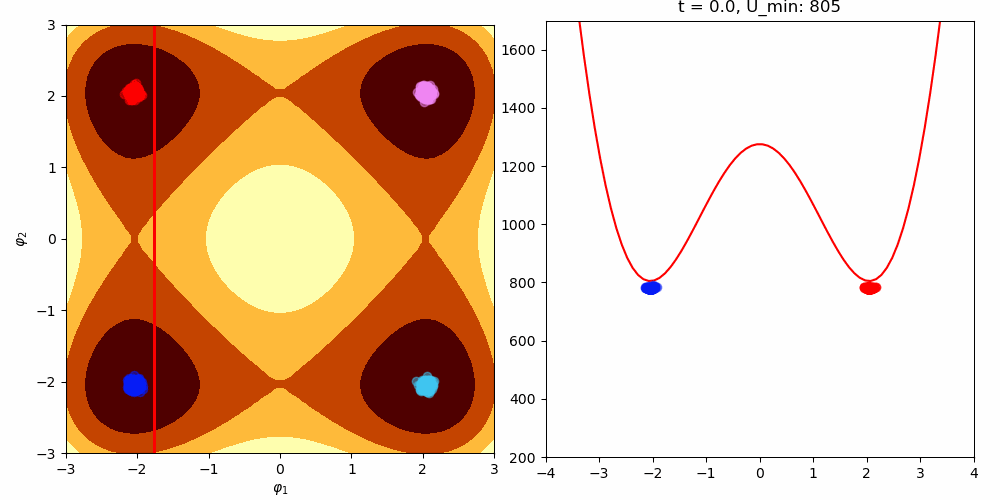

In [37]:
Image(filename="scatter.gif")

In [135]:
import sys, importlib
importlib.reload(sys.modules['edward_tools.coupled_fq_protocol_library'])
# from edward_tools.coupled_fq_protocol_library import work_analysis, KE_analysis, single_particle_analysis
animation_play = True
# animation_play = False
# contourData = {
#     "manual_domain": [np.array([-4, -4]), np.array([4, 4])],
#     "contour_range": [350, 1500], "domain_limit": [-3, 3],
#     "title": None
# }
contourData = {
    "manual_domain": [np.array([-4, -4]), np.array([4, 4])],
    "contour_range": [700, 1800], "domain_limit": [-3, 3],
    "title": None
}

cutlineInformation = {
    "cutlineList": [(2.3, "v","red")],
    "cutlineGeneratingFunction": None,
    "cutlineXLimit": [-4,4],
    "cutlineYLimit": [200, 1700]
}

particleInformation = {
    "showParticles": True,
    "project_item": ["10", "11"],
    "particle_opacity": 0.5,
    "pColor": {"00": "#061DF7", "01": "red", "10": "#3FC7F2", "11": "#F187F4"}
}


In [136]:

animation_play = True
# animation_play = False
if animation_play:
    frame_skip = 20
    targetTimeArray = protocol_all_time_array[simResult['cfqr'].sim.target_step_index]
    animation_time_array = targetTimeArray[::frame_skip]
    animation_states = all_state[:, ::frame_skip, ...]
    print("geenerated at ", datetime.datetime.now())

    
    ani, fig, ax = coupled_fq_protocol_library.animate_sim_flux_qubit_with_cutline_and_projection(simResult['cfqr'], time_array=animation_time_array, state_array = animation_states, plot_axis= [0,1],
                                                                                   vmin=graph_setting[T]['vmin'], vmax=graph_setting[T]['vmax'], ax0_title = f"T = {T}K, L = {L_1 * 1e12}pH",
                                                                                   params=params, cutlineGeneratingFunction = False, 
                                                                                   cutlineInformation = cutlineInformation, particleInformation = particleInformation, contourData = contourData,
                                                                                   pColor=pColor, contour_range = [0, 500], cutlineXLimit=[-4, 4], cutlineYLimit=[0, 500])
    fig.tight_layout()
    writer = animation.PillowWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('scatter.gif', writer=writer)
    plt.close()
    


geenerated at  2025-02-08 14:17:46.063449
new animation function
100


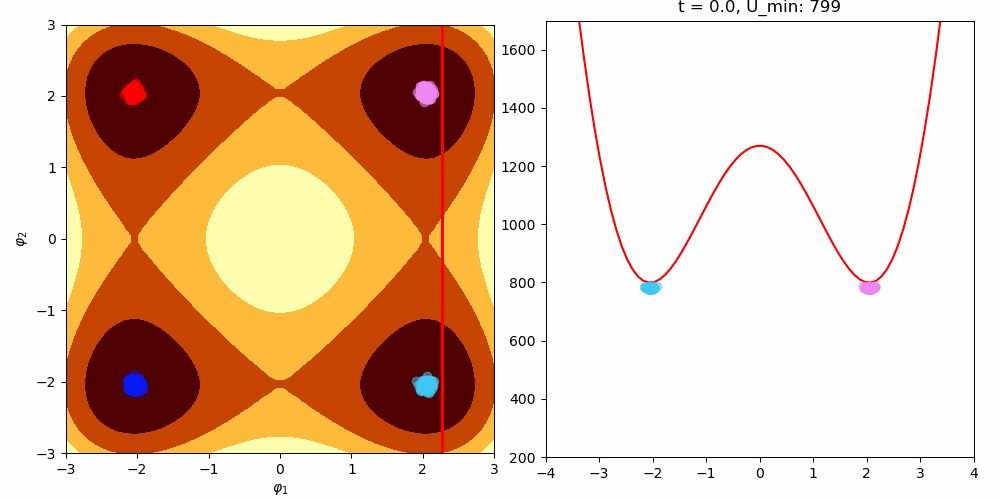

In [137]:
Image(filename="scatter.gif")

### with cutlineGeneratingFunction

geenerated at  2024-10-28 13:43:24.010377


KeyError: 'domain_limit'

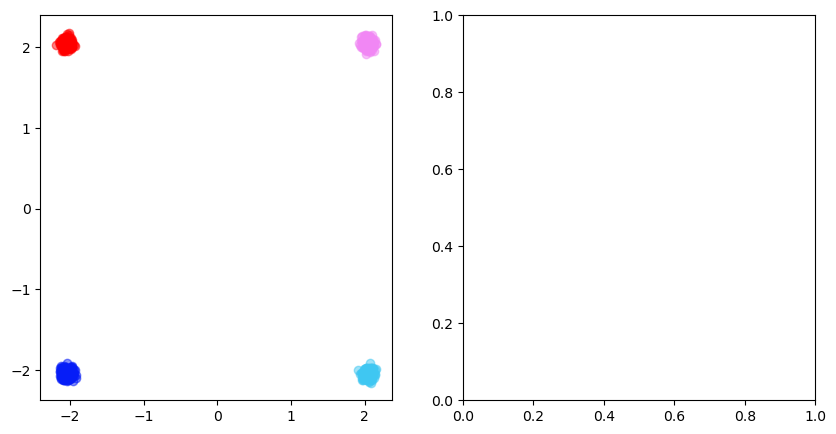

In [46]:
animation_play = True
# animation_play = False
if animation_play:

    frame_skip = int(1/50 * 1/params['dt'])
    print("geenerated at ", datetime.datetime.now())
    targetTimeArray = protocol_all_time_array[simResult['cfqr'].sim.target_step_index]
    ani, fig, ax = coupled_fq_protocol_library.animate_sim_flux_qubit_with_cutline_and_projection(simResult['cfqr'], time_array=targetTimeArray, frame_skip = frame_skip, plot_axis= [0,1],
                                                                                   vmin=graph_setting[T]['vmin'], vmax=graph_setting[T]['vmax'], ax0_title = f"T = {T}K, L = {L_1 * 1e12}pH",
                                                                                   params=params, cutlineGeneratingFunction = cutlineDataGeneratingFunction(initial_parameter_dict),
                                                                                   pColor=pColor, contour_range = [0, 500], cutlineXLimit=[-4, 4], cutlineYLimit=[0, 500])
    fig.tight_layout()
    writer = animation.PillowWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('scatter.gif', writer=writer)
    Image(filename="scatter.gif")

### save data analysis

In [ ]:
print(f"current comment: {params['comment']}")
response = input("Are you happy with the current comment? If not, give me a new comment.")
if response == "y":
    pass
else:
    params['comment'] = response

In [ ]:
simResult['error_rate_array']

In [ ]:
importlib.reload(sys.modules['edward_tools.cfq_batch_sweep'])

In [ ]:
cfq_batch_sweep.saveSimulationResult(simResult, U0_1, timeOrStep = 'step', save = True, save_final_state = False, saveFolderPath = "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery", save_all_state = False)

# save state

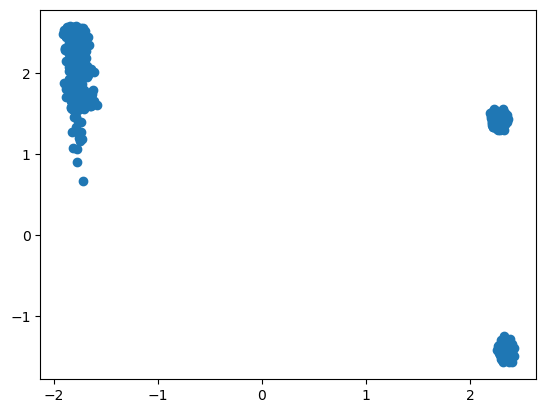

In [192]:
target_state = all_states[:,106, ...]
plt.scatter(target_state[..., 0, 0], target_state[..., 1, 0])

In [193]:
state_name = "just_before_KEP_N_1000.npy"
np.save("saved_init_state/" + state_name, target_state)

# save pickle

In [225]:
experiment_label = "Experiment 8 (2025-1-27)" 

In [176]:
with open(f'coupled_flux_qubit_protocol/simulation_protocol_history/{experiment_label}.pickle', "rb") as f:
    k = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'coupled_flux_qubit_protocol/simulation_protocol_history/Experiment 6 (2025-1-27).pickle'

In [95]:
k['params']['comment']

'Experiment 1 (2025-1-27): To study the trade-off between speed and work done, and also speed and fidelity CE_t_factor = 0.1'

In [226]:
export_cfqr_params = params['circuit_parameters']

export_params = params
export_params['comment'] = f"{experiment_label}: To study the trade-off between speed and work done, and also speed and fidelity CE_t_factor = 10"


export_object = {
    "cfqr_params": export_cfqr_params,
    "params": export_params,
    "initial_external_parameter_dict": initial_parameter_dict,
    "protocol_list": protocol_list,
    "manual_domain": [np.array([-5, -5]), np.array([5, 5])]
}
    

print(export_params['comment'])
print(simResult['simulation_data']['simulation_id'])

Experiment 8 (2025-1-27): To study the trade-off between speed and work done, and also speed and fidelity CE_t_factor = 10
788b90c4dea9a7c9554684a76c6a60de96771cf0fa445dd8ce6dd4c47074f042


In [180]:
pickle_file_path = os.path.join("coupled_flux_qubit_protocol", "simulation_protocol_history", f"{experiment_label}.pickle")

with open(pickle_file_path, "wb") as f:
    pickle.dump(export_object, f)

In [220]:
# modify pickle

In [221]:
modify_item = [(0, 200), (40, 160), (80, 120), (120, 80), (160, 40), (200, 0)]

In [90]:
import copy


In [91]:
k_array = []

In [96]:
for _i, (t_1, t_2) in enumerate(modify_item):
    k_template = copy.deepcopy(k)

        
    k_template['protocol_list'][1]['duration'] = t_1
    k_template['protocol_list'][2]['duration'] = t_2
    
    if t_1 == 0:
        k_template['protocol_list'].pop(1)
    if t_2 == 0:
        k_template['protocol_list'].pop(2)
    k_array.append(k_template)
    
    pickle_file_path = os.path.join("coupled_flux_qubit_protocol", "simulation_protocol_history", f"{experiment_label}_series_{_i}.pickle")

    with open(pickle_file_path, "wb") as f:
        pickle.dump(k_template, f)
    

In [93]:
for x in k_array:
    print(x['protocol_list'])

[{'duration': 100, 'phi_1_x': 0.59, 'phi_2_x': 0.09, 'M_12': 0.052, 'phi_1_dcx': 0, 'phi_2_dcx': 1.9, 'name': 'CE_1'}, {'duration': 200, 'phi_1_x': 0.59, 'phi_2_x': 0.0, 'M_12': 0.0, 'phi_1_dcx': 0, 'phi_2_dcx': 1.9, 'name': 'KE_extraction_protocol'}, {'duration': 100, 'phi_1_x': 0, 'phi_2_x': 0, 'M_12': 0, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'name': 'four well'}]
[{'duration': 100, 'phi_1_x': 0.59, 'phi_2_x': 0.09, 'M_12': 0.052, 'phi_1_dcx': 0, 'phi_2_dcx': 1.9, 'name': 'CE_1'}, {'duration': 40, 'phi_1_x': 0.59, 'phi_2_x': 0.0, 'M_12': 0.0, 'phi_1_dcx': 0, 'phi_2_dcx': 1.9, 'name': 'KE_extraction_protocol'}, {'duration': 160, 'phi_1_x': 0.59, 'phi_2_x': 0.0, 'M_12': 0.0, 'phi_1_dcx': 0, 'phi_2_dcx': 1.9, 'name': 'KE_extraction_protocol'}, {'duration': 100, 'phi_1_x': 0, 'phi_2_x': 0, 'M_12': 0, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'name': 'four well'}]
[{'duration': 100, 'phi_1_x': 0.59, 'phi_2_x': 0.09, 'M_12': 0.052, 'phi_1_dcx': 0, 'phi_2_dcx': 1.9, 'name': 'CE_1'}, {'duration': 80, 'phi_1

In [100]:
pickle_prefix = "Experiment 1 (2024-11-12)_series_"
# pickle_prefix = "Experiment 1 (2024-10-27)"
print(pickle_prefix)
comment = f"Experiment 1 (2024-11-12) CE operation, with R = 300Ω and various ratio of the KE protocol"
param_dt = 1/100
loopTime = 100
protocol_type = "CE"






####################
# no need to change the following 
####################

pickle_file_base_folder = "coupled_flux_qubit_protocol/simulation_protocol_history"

all_pickle_file = os.listdir(pickle_file_base_folder)
target_pickle_file_list = [os.path.join(pickle_file_base_folder, p) for p in all_pickle_file if pickle_prefix in p]


Experiment 1 (2024-11-12)_series_


In [101]:
target_pickle_file_list

['coupled_flux_qubit_protocol/simulation_protocol_history/Experiment 1 (2024-11-12)_series_4.pickle',
 'coupled_flux_qubit_protocol/simulation_protocol_history/Experiment 1 (2024-11-12)_series_2.pickle',
 'coupled_flux_qubit_protocol/simulation_protocol_history/Experiment 1 (2024-11-12)_series_0.pickle',
 'coupled_flux_qubit_protocol/simulation_protocol_history/Experiment 1 (2024-11-12)_series_5.pickle',
 'coupled_flux_qubit_protocol/simulation_protocol_history/Experiment 1 (2024-11-12)_series_3.pickle',
 'coupled_flux_qubit_protocol/simulation_protocol_history/Experiment 1 (2024-11-12)_series_1.pickle']

In [49]:
particle_index = 0
particle_category = "00"
time_range = None

index_choice = simResult['cfqr'].getIndexOfParticles()["00"]
all_states = simResult['cfqr'].sim.output.all_state['states']
all_states_00_i1 = all_states[index_choice][particle_index, ...]

In [50]:
_, _, protocol_time_array, protocol_time_index_array = simResult['cfqr'].createProtocolTimeArray(protocol_list, params)

protocol_all_time_index_array = np.array(range(0, int(np.array(protocol_time_array[-1]) / params['dt']) + 1))
protocol_all_time_array  = protocol_all_time_index_array * params['dt']



In [59]:
reduced_protocal_time_array = simResult['cfqr'].getKeyTime()
KE_of_the_particle = simResult['cfqr'].system.get_kinetic_energy(all_states_00_i1)
PE_of_the_particle = [simResult['cfqr'].system.get_potential(_s, _t ) for _t, _s in  zip(reduced_protocal_time_array, all_states_00_i1)]
WD_of_the_particle = simResult['cfqr'].sim.work_dist_time_array_whole_process[index_choice][particle_index]

In [67]:
keyState_choosen_particle = [ s[index_choice][particle_index, ...] for s in simResult['cfqr'].sim.keyStep_all_states]
total_energy = PE_of_the_particle - min(PE_of_the_particle) + KE_of_the_particle
adjusted_PE = PE_of_the_particle - PE_of_the_particle[0]
adjusted_total_energy = adjusted_PE + KE_of_the_particle
characteristic_t = np.sqrt(params['circuit_parameters']['L_1'] * params['circuit_parameters']['L_factor'] * params['circuit_parameters']['C_1'] * params['circuit_parameters']['C_factor'])


In [68]:
reduced_protocal_time_array

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [98]:
def search_protocol_time_array_index(array, start, end):
    x = np.sort(np.append(array, start))
    y = np.sort(np.append(array, end))
    
    start_index = np.where(x == start)[0][0]
    if start != round(array[start_index]):
        start_index += 1
    
    
    final_index = np.where(y == end)[0][0] 
    if end != round(array[final_index]):
        final_index -= 1

    return slice(start_index, final_index)

In [99]:
index_slice = search_protocol_time_array_index(reduced_protocal_time_array, 23, 60.)

# reduced_protocal_time_array[index_slice]
# search_protocol_time_array_range(adjusted_PE, 23, 60.)

In [103]:
reduced_protocal_time_array[index_slice]
KE_of_the_particle[None]

array([[7.80664239, 5.24103068, 4.47608392, 2.73895755, 3.70117766,
        1.47978808, 1.43809688, 0.21862529, 0.27127305, 0.62023623,
        0.44181904, 0.73954582, 1.19115258, 2.53054534, 4.15925031,
        2.34099538, 2.74449274, 2.37519653, 3.14924201, 2.68206883,
        3.90018465, 2.16275159, 2.11113491, 2.11608282, 1.82730145,
        1.37662994, 0.84975073, 1.61064026, 0.97055497, 1.68649863,
        1.56676858, 2.74892558, 3.05059894, 2.32886221, 4.92715234,
        3.3628132 , 4.68007466, 3.13769614, 2.8104348 , 3.91170108,
        2.65438973, 1.86249986, 1.66051782, 2.17297405, 2.57961918,
        1.10818381, 3.91497332, 1.31580874, 0.92182448, 3.09218519,
        1.49921384, 3.5389895 , 5.58261842, 1.187342  , 0.32084732,
        0.93358507, 1.30970149, 5.27819325, 4.3404002 , 2.87060632,
        6.5562866 , 1.50740714, 1.1924797 , 4.92538066, 2.57640785,
        2.91867505, 3.16903074, 0.63256874, 1.76773437, 0.69280842,
        0.7609466 , 1.18525582, 0.08035806, 0.91

In [93]:
export_object

NameError: name 'export_object' is not defined

In [ ]:
def single_particle_analysis(simResult, params, protocol_list, plot_ax = None, particle_index = 0, particle_category = "00", time_range = None):
    

    
    
    # _ = [simResult['cfqr'].system.get_potential(_s, _t ) for _s, _t in zip(keyState_choosen_particle, simResult['cfqr'].protocol_time_array)]
    
    
    

    if plot_ax == None:
        plt.figure(figsize=(8, 5))
    plot_ax.plot(protocal_key_time_array, adjusted_PE , label = "PE", color = "#CC79A7")
    plot_ax.plot(protocal_key_time_array, KE_of_the_particle, label = "KE")
    plot_ax.plot(protocal_key_time_array, adjusted_total_energy, label = "KE + PE")
    plot_ax.plot(protocal_key_time_array, WD_of_the_particle[::100], label = "WD", color = "#000000")
    plot_ax.plot(protocal_key_time_array, WD_of_the_particle[::100] - adjusted_total_energy, label = "energy loss")
    plot_ax.set_ylabel(r"energy $(k_BT)$")
    plot_ax.set_xlabel(f"time ({characteristic_t * 1e9:.3g} ns)")
    plot_ax.legend(bbox_to_anchor=(1.25, 1.05))

In [47]:
os.path.join("~", "source", "coupled_flux_qubit_protocol", "simulation_protocol_history", f"{245}.pickle")




'~/source/coupled_flux_qubit_protocol/simulation_protocol_history/245.pickle'

In [ ]:
"/Users/tkwtang/source/coupled_flux_qubit_protocol/simulation_protocol_history/"

# circuit parameter at different t and ∆U

In [71]:
reduced_time_array = cfqr.getReducedTimeArray()

In [72]:
params_at_t = [cfqr.convert_params_list_into_dict(cfqr.protocol.get_params(_t)) for _t in reduced_time_array]

In [73]:
circuit_parameters_at_different_t = []

for x in params_at_t:
    circuit_parameter_template = experiment_circuit_params.copy()
    circuit_parameter_template['phi_1x'] = x['phi_1_x']
    circuit_parameter_template['phi_2x'] = x['phi_2_x']
    circuit_parameter_template['phi_1xdc'] = x['phi_1_dcx']
    circuit_parameter_template['phi_2xdc'] = x['phi_2_dcx']
    circuit_parameter_template['M_12'] = x['M_12']
    circuit_parameters_at_different_t.append(circuit_parameter_template)

In [79]:
from edward_tools.pot_analysis_helper_functions import get_XYU, pot_function, find_all_critical_points_for_all_potential

In [80]:
contour_data_array = [get_XYU(circuit_params, domain=[-4, 4], resolution=500) for circuit_params in circuit_parameters_at_different_t]


In [81]:
initial_guess = [(-2, -2), (-2, 2), (2, -2), (2, 2), (-2,0), (0, -2), (2, 0), (0, 2)]
critical_points_color = ["green", "red", "yellow", "orange", "white", "white", "white", "white"]

In [101]:
k_BT

5.796000000000001e-23

In [98]:
result_array = []
for _cp in circuit_parameters_at_different_t:
    critical_dict = find_all_critical_points_for_all_potential(_cp,
                    guess = [(-2, -2), (-2, 2), (2, -2), (2, 2), \
                             (-2,0), (0, -2), (2, 0), (0, 2)])
    critical_points = list(critical_dict.values())[0]
    critical_potential = [pot_function(_cp)([x, y]) for x, y in critical_points]
    delta_U00 = critical_potential[4] - critical_potential[1]
    delta_U01 = critical_potential[5] - critical_potential[0]
    delta_U10 = critical_potential[6] - critical_potential[2]
    delta_U11 = critical_potential[6] - critical_potential[3]

    X, Y, U = get_XYU(_cp, [-4, 4], 50)

    result_array.append({
        "coord": critical_points, "delta_U00": delta_U00, "delta_U01": delta_U01,
        "delta_U10": delta_U10, "delta_U11": delta_U11
    })


In [99]:
delta_U_data = [(item['delta_U00'], item['delta_U01'], item['delta_U10'], item['delta_U11'])  for item in result_array]

Text(0.5, 1.0, '∆U00 vs t (total duration = 0.664ns) ')

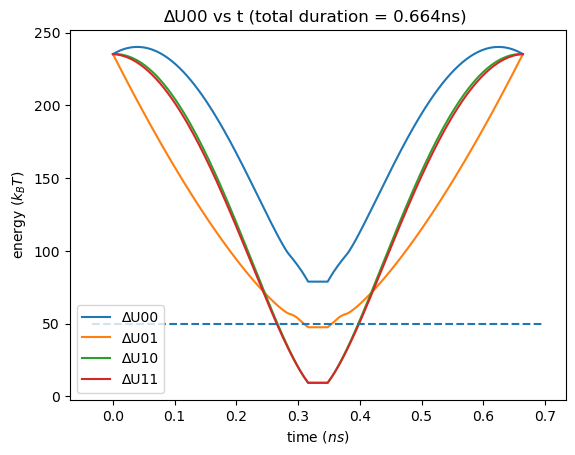

In [114]:
total_duration = protocol_time_array[-1] * characteristic_time * 1e9

plt.plot(reduced_time_array * characteristic_time * 1e9, U0_1 * np.array(delta_U_data)[:, 0], label = "∆U00")
plt.plot(reduced_time_array * characteristic_time * 1e9, U0_1 * np.array(delta_U_data)[:, 1], label = "∆U01")
plt.plot(reduced_time_array * characteristic_time * 1e9, U0_1 * np.array(delta_U_data)[:, 2], label = "∆U10")
plt.plot(reduced_time_array * characteristic_time * 1e9, U0_1 * np.array(delta_U_data)[:, 3], label = "∆U11")
xmin, xmax = plt.xlim()
plt.hlines(y = 50, xmin = xmin, xmax = xmax, linestyle = "--")
plt.legend()
plt.xlabel(r'time $(ns)$')
plt.ylabel(r'energy $(k_BT)$')
plt.title(f"∆U00 vs t (total duration = {total_duration:.3g}ns) ")


6.640783086353597e-10

# save all states

In [269]:
base_folder = "cfq_data/sudden_jump_KEP/"
prefix = "KEP(jump)"
name_of_state_file = prefix + "_all_state.npy"
name_of_reduced_time_array_file = prefix + "_reduced_time_array.npy"
name_of_index_file = prefix + "_index_of_particle.npy"

np.save(os.path.join(base_folder, name_of_reduced_time_array_file), reduced_protocal_time_array)
np.save(os.path.join(base_folder, name_of_state_file), all_states)
np.save(os.path.join(base_folder, name_of_index_file), simResult['cfqr'].getIndexOfParticles())

{'00': array([False, False, False, False,  True, False,  True, False,  True,
        False, False,  True,  True,  True, False,  True,  True, False,
         True, False,  True,  True,  True, False, False, False, False,
         True, False, False,  True, False,  True, False, False,  True,
        False,  True, False,  True, False,  True, False, False, False,
        False,  True, False, False,  True,  True, False, False, False,
         True, False, False, False, False, False,  True, False, False,
        False,  True, False, False, False, False, False,  True,  True,
        False, False, False,  True, False, False, False, False,  True,
         True, False, False, False,  True,  True, False, False, False,
         True, False, False, False, False, False, False, False, False,
        False,  True,  True, False, False,  True,  True, False,  True,
        False, False,  True, False,  True,  True, False, False,  True,
        False, False, False, False, False,  True, False, False, False,


Text(0, 0.5, 'Potential')

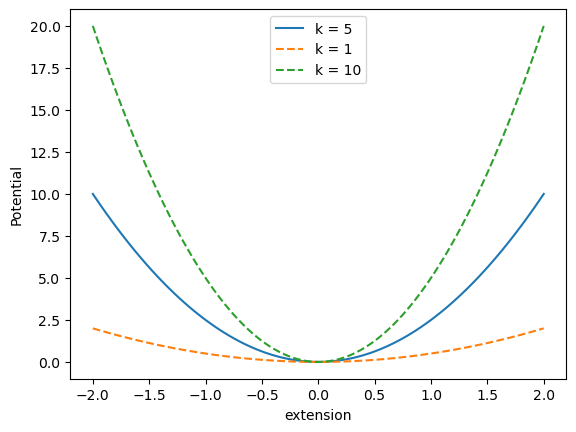